In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,GRU
from sklearn.preprocessing import StandardScaler

data = pd.read_csv('merged_df.csv')
stocks = pd.read_csv('AAL.csv')

print(data.head())
print(stocks.head())

         date     WSJ  Fortune    CNBC
0  01/12/2017 -0.0082  -0.4215 -0.8126
1  02/12/2017 -0.6760   0.0000  0.0000
2  03/12/2017 -0.8658   0.0000  0.0000
3  04/12/2017  0.7993   0.5859  0.4767
4  05/12/2017 -0.7342  -0.3182 -0.6597
         Date       Open       High        Low      Close  Adj Close   Volume
0  2017-12-01  49.669998  50.380001  48.689999  49.000000  47.758640  6229600
1  2017-12-04  50.099998  51.470001  49.650002  49.930000  48.665085  7113800
2  2017-12-05  49.849998  50.000000  49.209999  49.470001  48.216736  3594000
3  2017-12-06  49.389999  49.810001  49.189999  49.610001  48.353188  2835500
4  2017-12-07  49.529999  50.919998  49.299999  50.880001  49.591015  3047000


In [2]:
stocks = stocks.drop(['Open','High','Low','Close','Volume'],axis=1)
data['date'] = pd.to_datetime(data['date'],format='%d/%m/%Y')
stocks['Date'] = pd.to_datetime(stocks['Date'],format='%Y-%m-%d')
stocks = stocks[(stocks['Date'] >= '2017-12-01') & (stocks['Date'] <= '2018-06-30')]
stocks = stocks.rename(columns ={'Date':'date'})

print(data.head())
print(stocks.head())

        date     WSJ  Fortune    CNBC
0 2017-12-01 -0.0082  -0.4215 -0.8126
1 2017-12-02 -0.6760   0.0000  0.0000
2 2017-12-03 -0.8658   0.0000  0.0000
3 2017-12-04  0.7993   0.5859  0.4767
4 2017-12-05 -0.7342  -0.3182 -0.6597
        date  Adj Close
0 2017-12-01  47.758640
1 2017-12-04  48.665085
2 2017-12-05  48.216736
3 2017-12-06  48.353188
4 2017-12-07  49.591015


In [3]:
df = pd.merge(data, stocks, on='date', how='outer')
nan_rows = df[df.iloc[:, 4].isna()]
df = df.drop(nan_rows.index)
df.head()

,date,WSJ,Fortune,CNBC,Adj Close
0,2017-12-01,-0.0082,-0.4215,-0.8126,47.758640
3,2017-12-04,0.7993,0.5859,0.4767,48.665085
4,2017-12-05,-0.7342,-0.3182,-0.6597,48.216736
5,2017-12-06,-0.4956,0.0772,0.2732,48.353188
6,2017-12-07,0.3612,0.9943,0.4019,49.591015


In [4]:
cols = list(df)[1:5]
df_for_training = df[cols].astype(float)
# df_for_training = df_for_training[(df_for_training['date'] >= '2017-12-01') & (df_for_training['date'] <= '2018-05-04')]
df_for_training.head()

,WSJ,Fortune,CNBC,Adj Close
0,-0.0082,-0.4215,-0.8126,47.758640
3,0.7993,0.5859,0.4767,48.665085
4,-0.7342,-0.3182,-0.6597,48.216736
5,-0.4956,0.0772,0.2732,48.353188
6,0.3612,0.9943,0.4019,49.591015


In [5]:
scaler = StandardScaler()
df_for_training['Adj Close'] = scaler.fit_transform(df_for_training['Adj Close'].values.reshape(-1,1))
print(df_for_training.head())
df_for_training_scaled = df_for_training.values
print(df_for_training_scaled)

      WSJ  Fortune    CNBC  Adj Close
0 -0.0082  -0.4215 -0.8126  -0.026866
3  0.7993   0.5859  0.4767   0.154579
4 -0.7342  -0.3182 -0.6597   0.064832
5 -0.4956   0.0772  0.2732   0.092146
6  0.3612   0.9943  0.4019   0.339926
[[-0.0082     -0.4215     -0.8126     -0.0268664 ]
 [ 0.7993      0.5859      0.4767      0.15457947]
 [-0.7342     -0.3182     -0.6597      0.06483208]
 [-0.4956      0.0772      0.2732      0.09214609]
 [ 0.3612      0.9943      0.4019      0.33992571]
 [-0.9655      0.          0.          0.36723973]
 [-0.2937      0.         -0.6258      0.42186756]
 [-0.991      -0.8126      0.5994      0.25993476]
 [-0.6705      0.8591      0.7717      0.18579306]
 [ 0.8797     -0.34        0.4215      0.2092073 ]
 [-0.7935     -0.765       0.5267      0.37504448]
 [-0.7506     -0.34        0.2582      0.45893721]
 [-0.9581      0.1027     -0.7814      0.44918157]
 [-0.8277      0.          0.795       0.54283094]
 [ 0.2263      0.4939      0.5994      0.71257149]
 [ 0.92

In [6]:
trainX = []
trainY = []

n_future = 1 #predict 1 day in future
n_past = 10 #use days for prediction

for i in range(n_past,len(df_for_training_scaled)-n_future +1):
    trainX.append(df_for_training_scaled[i-n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i+n_future-1: i+n_future, 0])

trainX,trainY = np.array(trainX),np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (135, 10, 4).
trainY shape == (135, 1).


In [7]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))  # Output layer

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

c:\Users\anasa\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 50)         │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 10, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,651 (279.89 KB)

 Trainable params: 71,651 (279.89 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history = model.fit(trainX,trainY,epochs=100,batch_size=4,validation_split=0.1,verbose=1)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 0.7032 - val_loss: 0.8188
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.6727 - val_loss: 0.8220
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.7001 - val_loss: 0.9262
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.6413 - val_loss: 0.8197
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6708 - val_loss: 0.8412
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5330 - val_loss: 0.8058
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6106 - val_loss: 0.8037
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6360 - val_loss: 0.7966
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5968 - val_loss: 0.7619
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.5738 - val_loss: 0.7694
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.6166 - val_loss: 0.7720
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step

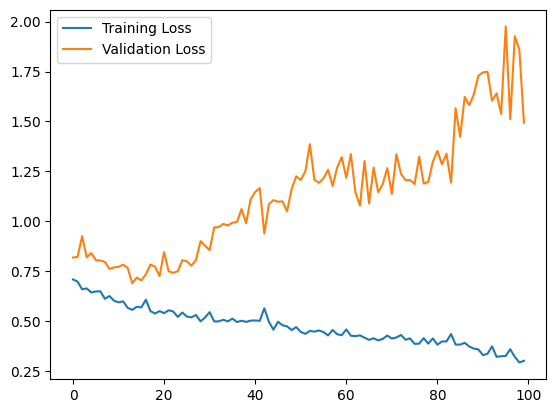

In [9]:
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.legend()

In [10]:
train_dates = pd.to_datetime(df['date'])
future = 30
forecast_period_dates = pd.date_range(list(train_dates)[-1],periods=future,freq='1d').tolist

forecast = model.predict(trainX[-future:])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step


In [11]:
print(forecast_period_dates)
print(forecast)

<bound method IndexOpsMixin.tolist of DatetimeIndex(['2018-06-29', '2018-06-30', '2018-07-01', '2018-07-02',
               '2018-07-03', '2018-07-04', '2018-07-05', '2018-07-06',
               '2018-07-07', '2018-07-08', '2018-07-09', '2018-07-10',
               '2018-07-11', '2018-07-12', '2018-07-13', '2018-07-14',
               '2018-07-15', '2018-07-16', '2018-07-17', '2018-07-18',
               '2018-07-19', '2018-07-20', '2018-07-21', '2018-07-22',
               '2018-07-23', '2018-07-24', '2018-07-25', '2018-07-26',
               '2018-07-27', '2018-07-28'],
              dtype='datetime64[ns]', freq='D')>
[[ 0.89999014]
 [ 0.9289494 ]
 [ 1.030211  ]
 [ 0.9147672 ]
 [ 0.85984266]
 [ 0.9455946 ]
 [-0.90021974]
 [-0.6885573 ]
 [ 0.49775058]
 [-1.0404826 ]
 [-0.8934704 ]
 [-0.8482735 ]
 [-0.6867588 ]
 [-0.5155822 ]
 [-0.12009212]
 [-0.47838908]
 [-0.20547837]
 [-0.31610292]
 [-0.96326774]
 [-0.9623757 ]
 [-0.85562634]
 [-0.6220044 ]
 [-0.29382414]
 [ 0.67323524]
 [ 0.8424226

In [12]:
# forecast_copies = np.repeat(forecast,df_for_training.shape[1],axis=-1)
y_pred_future = scaler.inverse_transform(forecast)

In [13]:
print(y_pred_future)

[[52.388916]
 [52.53359 ]
 [53.039455]
 [52.462738]
 [52.18835 ]
 [52.61674 ]
 [43.39565 ]
 [44.453045]
 [50.379456]
 [42.69494 ]
 [43.429367]
 [43.655155]
 [44.462032]
 [45.317173]
 [47.292915]
 [45.50298 ]
 [46.866352]
 [46.31371 ]
 [43.08068 ]
 [43.085136]
 [43.618423]
 [44.785522]
 [46.425007]
 [51.256123]
 [52.101326]
 [45.09372 ]
 [44.559513]
 [50.53804 ]
 [48.87458 ]
 [50.74447 ]]


In [14]:
model_GRU = Sequential()
model_GRU.add(GRU(units=50, return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model_GRU.add(Dropout(0.2))
model_GRU.add(GRU(units=50, return_sequences=True))
model_GRU.add(Dropout(0.2))
model_GRU.add(GRU(units=50, return_sequences=True))
model_GRU.add(Dropout(0.2))
model_GRU.add(GRU(units=50, return_sequences=False))
model_GRU.add(Dropout(0.2))
model_GRU.add(Dense(trainY.shape[1]))  # Output layer
model_GRU.compile(optimizer='adam', loss='mean_squared_error')
model_GRU.summary()

c:\Users\anasa\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 10, 50)         │         8,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 10, 50)         │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 10, 50)         │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,351 (212.31 KB)

 Trainable params: 54,351 (212.31 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2861 - val_loss: 1.8684
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3229 - val_loss: 1.4000
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2906 - val_loss: 1.8708
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2892 - val_loss: 1.5432
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.2043 - val_loss: 1.8547
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2725 - val_loss: 1.1620
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2606 - val_loss: 1.8057
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.2490 - val_loss: 1.9144
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1962 - val_loss: 2.1692
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.2194 - val_loss: 1.4610
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.2806 - val_loss: 1.9263
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step

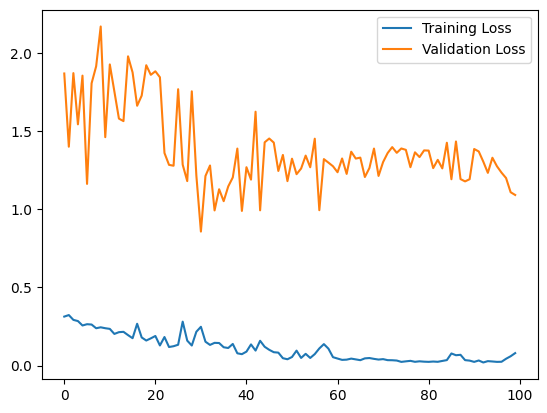

In [15]:
history_gru = model.fit(trainX,trainY,epochs=100,batch_size=4,validation_split=0.1,verbose=1)
plt.plot(history_gru.history['loss'],label='Training Loss')
plt.plot(history_gru.history['val_loss'],label='Validation Loss')
plt.legend()

In [16]:
forecast_gru = model_GRU.predict(trainX[-future:])
y_pred_future_gru = scaler.inverse_transform(forecast_gru)
print(y_pred_future_gru)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step
[[48.369183]
 [48.354496]
 [48.32535 ]
 [48.284958]
 [48.227917]
 [48.20787 ]
 [48.185394]
 [48.192036]
 [48.24831 ]
 [48.318665]
 [48.391598]
 [48.436012]
 [48.448097]
 [48.447327]
 [48.409   ]
 [48.361855]
 [48.297283]
 [48.25729 ]
 [48.208855]
 [48.185307]
 [48.162193]
 [48.169025]
 [48.219913]
 [48.262577]
 [48.314545]
 [48.35428 ]
 [48.40779 ]
 [48.419434]
 [48.473846]
 [48.557434]]


In [17]:
df_l2 = pd.DataFrame({'LSTM': y_pred_future.flatten(), 'GRU': y_pred_future_gru.flatten()})
df_l2.head()

,LSTM,GRU
0,52.388916,48.369183
1,52.533588,48.354496
2,53.039455,48.325352
3,52.462738,48.284958
4,52.188351,48.227917


In [18]:
scaler_meta = StandardScaler()
scaler_meta = scaler_meta.fit(df_l2)
df_l2_scaled = scaler_meta.transform(df_l2)
print(df_l2_scaled)

[[ 1.36381     0.50848   ]
 [ 1.4036664   0.3664733 ]
 [ 1.5430298   0.08467291]
 [ 1.3841475  -0.305901  ]
 [ 1.3085554  -0.8574404 ]
 [ 1.4265745  -1.0512704 ]
 [-1.1137829  -1.268596  ]
 [-0.8224765  -1.2043796 ]
 [ 0.8102152  -0.66025394]
 [-1.3068244   0.02001373]
 [-1.1044937   0.72521555]
 [-1.0422904   1.1546661 ]
 [-0.8200005   1.2715174 ]
 [-0.58441424  1.2640667 ]
 [-0.04010866  0.8934843 ]
 [-0.53322566  0.43762422]
 [-0.15762436 -0.18672596]
 [-0.30987424 -0.57342696]
 [-1.2005547  -1.0417541 ]
 [-1.1993272  -1.2694443 ]
 [-1.0524099  -1.4929298 ]
 [-0.73088086 -1.4268689 ]
 [-0.2792124  -0.9348249 ]
 [ 1.0517318  -0.52230453]
 [ 1.2845806  -0.01982193]
 [-0.6459744   0.36437085]
 [-0.7931451   0.8817918 ]
 [ 0.8539043   0.99436444]
 [ 0.39563087  1.5204903 ]
 [ 0.9107742   2.3287115 ]]


In [19]:
trainX_meta = []
trainY_meta = []

n_future = 1 #predict 1 day in future
n_past = 10 #use days for prediction

for i in range(n_past,len(df_l2_scaled)-n_future +1):
    trainX_meta.append(df_l2_scaled[i-n_past:i, 0:df_l2.shape[1]])
    trainY_meta.append(df_l2_scaled[i+n_future-1: i+n_future, 0])

trainX_meta,trainY_meta = np.array(trainX_meta),np.array(trainY_meta)

print('trainX_meta shape == {}.'.format(trainX_meta.shape))
print('trainY_meta shape == {}.'.format(trainY_meta.shape))

trainX_meta shape == (20, 10, 2).
trainY_meta shape == (20, 1).


In [20]:
print(trainX_meta.shape)

(20, 10, 2)


In [21]:
# trainX_meta_shape = trainX_meta.shape

# # Flatten the input data
# trainX_meta_flattened = trainX_meta.reshape(-1,20)

model = Sequential()
    
# Add the fully connected layers
model.add(Dense(64, input_shape=(trainX_meta.shape[1], trainX_meta.shape[2]), activation='relu'))  # First hidden layer
model.add(Dense(32, activation='relu'))  # Second hidden layer
model.add(Dense(16, activation='relu'))  # Third hidden layer

# Output layer - adjust the activation function based on the task
model.add(Dense(trainY_meta.shape[1], activation='linear'))  

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

c:\Users\anasa\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 10, 64)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10, 32)         │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10, 16)         │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10, 1)          │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,817 (11.00 KB)

 Trainable params: 2,817 (11.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/90
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.8455 - val_loss: 0.4806
Epoch 2/90
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6797 - val_loss: 0.5786
Epoch 3/90
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6166 - val_loss: 0.6828
Epoch 4/90
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5540 - val_loss: 0.7816
Epoch 5/90
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5281 - val_loss: 0.8811
Epoch 6/90
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5628 - val_loss: 0.9686
Epoch 7/90
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5112 - val_loss: 1.0177
Epoch 8/90
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.4966 - val_loss: 1.0487
Epoch 9/90
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5283 - val_loss: 1.0373
Epoch 10/90
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5389 - val_loss: 1.0364
Epoch 11/90
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5350 - val_loss: 1.0269
Epoch 12/90
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4965 - val_loss: 1.0087
E

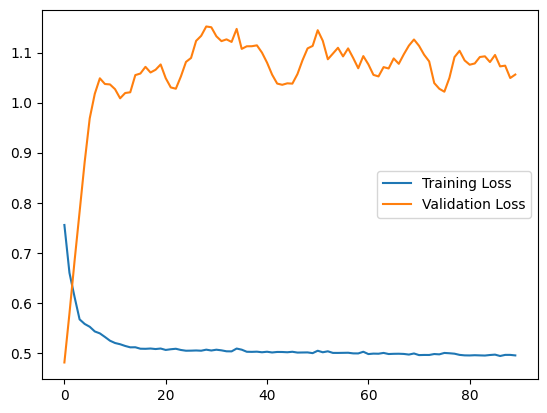

In [22]:
history_meta = model.fit(trainX_meta,trainY_meta,epochs=90,batch_size=5,validation_split=0.1,verbose=1)
plt.plot(history_meta.history['loss'],label='Training Loss')
plt.plot(history_meta.history['val_loss'],label='Validation Loss')
plt.legend()

In [23]:
forecast_meta = model_GRU.predict(trainX[-future:])
forecast_copies = np.repeat(forecast_meta,df_l2.shape[1],axis=-1)
y_pred_future_meta = scaler_meta.inverse_transform(forecast_copies)[:,0]
print(y_pred_future_meta)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[47.7846   47.77393  47.752754 47.723404 47.681957 47.66739  47.651062
 47.655888 47.696777 47.747894 47.800888 47.83316  47.841938 47.84138
 47.813534 47.779274 47.732357 47.7033   47.668106 47.650997 47.634205
 47.639168 47.67614  47.70714  47.7449   47.773773 47.812653 47.821114
 47.86065  47.921383]


In [24]:
forecast_period_dates = pd.date_range(list(train_dates)[-1],periods=future,freq='1d')
print(forecast_period_dates)

DatetimeIndex(['2018-06-29', '2018-06-30', '2018-07-01', '2018-07-02',
               '2018-07-03', '2018-07-04', '2018-07-05', '2018-07-06',
               '2018-07-07', '2018-07-08', '2018-07-09', '2018-07-10',
               '2018-07-11', '2018-07-12', '2018-07-13', '2018-07-14',
               '2018-07-15', '2018-07-16', '2018-07-17', '2018-07-18',
               '2018-07-19', '2018-07-20', '2018-07-21', '2018-07-22',
               '2018-07-23', '2018-07-24', '2018-07-25', '2018-07-26',
               '2018-07-27', '2018-07-28'],
              dtype='datetime64[ns]', freq='D')


In [25]:
meta_results = pd.DataFrame({'Date':forecast_period_dates,'pred':y_pred_future_meta})
# print(results['Dates']
print(meta_results)

         Date       pred
0  2018-06-29  47.784599
1  2018-06-30  47.773930
2  2018-07-01  47.752754
3  2018-07-02  47.723404
4  2018-07-03  47.681957
5  2018-07-04  47.667389
6  2018-07-05  47.651062
7  2018-07-06  47.655888
8  2018-07-07  47.696777
9  2018-07-08  47.747894
10 2018-07-09  47.800888
11 2018-07-10  47.833160
12 2018-07-11  47.841938
13 2018-07-12  47.841381
14 2018-07-13  47.813534
15 2018-07-14  47.779274
16 2018-07-15  47.732357
17 2018-07-16  47.703300
18 2018-07-17  47.668106
19 2018-07-18  47.650997
20 2018-07-19  47.634205
21 2018-07-20  47.639168
22 2018-07-21  47.676140
23 2018-07-22  47.707142
24 2018-07-23  47.744900
25 2018-07-24  47.773773
26 2018-07-25  47.812653
27 2018-07-26  47.821114
28 2018-07-27  47.860649
29 2018-07-28  47.921383


In [28]:
y_test = pd.read_csv('AAL_test.csv')
y_test = y_test.drop(['Open','High','Low','Close','Volume'],axis=1)
meta_results['Date'] = pd.to_datetime(meta_results['Date'],format='%Y-%m-%d')
y_test['Date'] = pd.to_datetime(y_test['Date'],format='%Y-%m-%d')
results_df = pd.merge(y_test, meta_results, on='Date', how='inner')
results_df

,Date,Adj Close,pred
0,2018-06-29,37.156166,47.784599
1,2018-07-02,37.547703,47.723404
2,2018-07-03,36.950615,47.681957
3,2018-07-05,37.185535,47.651062
4,2018-07-06,37.283413,47.655888
5,2018-07-09,38.477581,47.800888
6,2018-07-10,38.291603,47.833160
7,2018-07-11,35.198521,47.841938
8,2018-07-12,35.560688,47.841381
9,2018-07-13,36.333958,47.813534


In [29]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
mse = mean_squared_error(results_df['pred'], results_df['Adj Close'])
mae = mean_absolute_error(results_df['pred'], results_df['Adj Close'])
print("Mean Squared Error: ", mse)
print("Mean Absolute Error: ", mae)

Mean Squared Error:  111.81504060350657
Mean Absolute Error:  10.530957101269532
